In [70]:
# Install packages
!pip install --quiet optuna category_encoders imblearn xgboost matplotlib pandas scikit-learn numpy tensorflow

# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import xgboost as xgb
import optuna

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from category_encoders import TargetEncoder
from imblearn.pipeline import Pipeline

In [75]:
# Load the data
application_df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [76]:
# Data Preprocessing
application_df['ASK_AMT_LOG'] = np.log(application_df['ASK_AMT'] + 1)

In [77]:
# Target encoding for CLASSIFICATION
encoder = TargetEncoder(cols=['CLASSIFICATION'])
application_df['CLASSIFICATION_ENCODED'] = encoder.fit_transform(
    application_df['CLASSIFICATION'], application_df['IS_SUCCESSFUL']
)

In [78]:
# Drop non-beneficial columns
application_df = application_df.drop(columns=['EIN', 'NAME', 'ASK_AMT', 'CLASSIFICATION'])

In [79]:
# Group rare APPLICATION_TYPE values
app_counts = application_df['APPLICATION_TYPE'].value_counts()
application_types_to_replace = list(app_counts[app_counts < 500].index)
for app in application_types_to_replace:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app, "Other")

In [80]:
# Define features and target
X = application_df.drop(columns=['IS_SUCCESSFUL'])
y = application_df['IS_SUCCESSFUL']

In [81]:
# Identify column types
numerical_cols = ['STATUS', 'ASK_AMT_LOG', 'CLASSIFICATION_ENCODED']
categorical_cols = ['APPLICATION_TYPE', 'AFFILIATION', 'USE_CASE',
                    'ORGANIZATION', 'INCOME_AMT', 'SPECIAL_CONSIDERATIONS']

In [82]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ])

In [83]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [84]:
# Scale data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [85]:
# Build Neural Network
nn = tf.keras.models.Sequential()
nn.add(tf.keras.layers.InputLayer(input_shape=(X_train_scaled.shape[1],)))
nn.add(tf.keras.layers.Dense(units=128, activation='relu'))
nn.add(tf.keras.layers.Dense(units=64, activation='relu'))
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,313 (52.00 KB)

 Trainable params: 13,313 (52.00 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
# Train Neural Network
history = nn.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    verbose=2
)

Epoch 1/100
858/858 - 5s - 5ms/step - accuracy: 0.7224 - loss: 0.5659 - val_accuracy: 0.7235 - val_loss: 0.5638
Epoch 2/100
858/858 - 2s - 3ms/step - accuracy: 0.7301 - loss: 0.5555 - val_accuracy: 0.7293 - val_loss: 0.5601
Epoch 3/100
858/858 - 3s - 3ms/step - accuracy: 0.7305 - loss: 0.5533 - val_accuracy: 0.7248 - val_loss: 0.5605
Epoch 4/100
858/858 - 5s - 6ms/step - accuracy: 0.7318 - loss: 0.5511 - val_accuracy: 0.7241 - val_loss: 0.5583
Epoch 5/100
858/858 - 3s - 3ms/step - accuracy: 0.7334 - loss: 0.5507 - val_accuracy: 0.7258 - val_loss: 0.5567
Epoch 6/100
858/858 - 3s - 3ms/step - accuracy: 0.7327 - loss: 0.5484 - val_accuracy: 0.7257 - val_loss: 0.5567
Epoch 7/100
858/858 - 3s - 3ms/step - accuracy: 0.7320 - loss: 0.5485 - val_accuracy: 0.7280 - val_loss: 0.5546
Epoch 8/100
858/858 - 2s - 3ms/step - accuracy: 0.7330 - loss: 0.5467 - val_accuracy: 0.7232 - val_loss: 0.5566
Epoch 9/100
858/858 - 2s - 2ms/step - accuracy: 0.7334 - loss: 0.5463 - val_accuracy: 0.7224 - val_loss:

In [87]:
# Evaluate Neural Network
nn_loss, nn_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"\nNeural Network - Loss: {nn_loss:.4f}, Accuracy: {nn_accuracy:.4f}")

215/215 - 0s - 2ms/step - accuracy: 0.7239 - loss: 0.5778

Neural Network - Loss: 0.5778, Accuracy: 0.7239


In [90]:
# XGBoost Model with Optuna Optimization
print("\n---XGBoost Hyperparameter Tuning---")

# Preprocess entire dataset for tuning
X_processed = preprocessor.fit_transform(X)

# Cross-Validation Setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 0.5),
        'random_state': 42,
        'tree_method': 'hist',
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }

    model = xgb.XGBClassifier(**params)
    score = cross_val_score(model, X_processed, y, cv=skf, scoring='accuracy', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print(f"Best accuracy: {study.best_trial.value:.4f}")
print("Best parameters:")
print(study.best_params)

[I 2025-05-26 18:35:06,061] A new study created in memory with name: no-name-292b8ec0-64b8-49dd-925b-22cabc09f905



---XGBoost Hyperparameter Tuning---


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-26 18:35:20,900] Trial 0 finished with value: 0.7278928963541762 and parameters: {'n_estimators': 946, 'learning_rate': 0.11684912606530193, 'max_depth': 4, 'subsample': 0.8255030274430937, 'colsample_bytree': 0.8840685478495627, 'gamma': 0.35381616982433367, 'reg_alpha': 0.1727505244275469, 'reg_lambda': 0.30762192129561977}. Best is trial 0 with value: 0.7278928963541762.
[I 2025-05-26 18:35:32,093] Trial 1 finished with value: 0.7307210122088532 and parameters: {'n_estimators': 658, 'learning_rate': 0.012638163429727529, 'max_depth': 6, 'subsample': 0.8412913165195224, 'colsample_bytree': 0.6979305155341546, 'gamma': 0.13369417844003428, 'reg_alpha': 0.39609199970961195, 'reg_lambda': 0.017698862649759894}. Best is trial 1 with value: 0.7307210122088532.
[I 2025-05-26 18:35:37,742] Trial 2 finished with value: 0.7301961968633495 and parameters: {'n_estimators': 254, 'learning_rate': 0.05215811867400204, 'max_depth': 6, 'subsample': 0.9019024217047108, 'colsample_bytree': 

In [92]:
# Final Training with Best Parameters
print("\n---Training Final XGBoost Model---")

best_params = study.best_params
best_params.update({
    'objective': 'binary:logistic',
    'random_state': 42,
    'tree_method': 'hist',
    'eval_metric': 'logloss',
    'use_label_encoder': False
})

# Use preprocessed full dataset for training
X_final = preprocessor.fit_transform(X)
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_final, y)

# Evaluate final model
y_pred = final_model.predict(X_final)
y_proba = final_model.predict_proba(X_final)[:, 1]

print("\nFinal XGBoost Model Evaluation:")
print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y, y_proba):.4f}")
print("\nClassification Report:\n", classification_report(y, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y, y_pred))


---Training Final XGBoost Model---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:55:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Final XGBoost Model Evaluation:
Accuracy: 0.7502
ROC AUC: 0.8155

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.68      0.72     16038
           1       0.74      0.81      0.77     18261

    accuracy                           0.75     34299
   macro avg       0.75      0.75      0.75     34299
weighted avg       0.75      0.75      0.75     34299


Confusion Matrix:
 [[10986  5052]
 [ 3517 14744]]


<Figure size 1200x800 with 0 Axes>

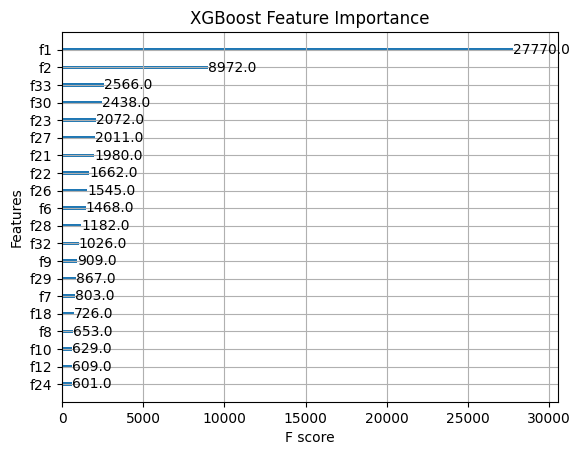

In [93]:
# Feature Importance Plot
plt.figure(figsize=(12, 8))
xgb.plot_importance(final_model, max_num_features=20)
plt.title("XGBoost Feature Importance")
plt.show()

In [94]:
# Save models
nn.save("AlphabetSoupCharity_NN.h5")
final_model.save_model("AlphabetSoupCharity_XGBoost.json")